<a href="https://colab.research.google.com/github/arielnbg/Identificao-Automatizada-da-Femea-do-Aedes-aegypti-com-Redes-Neurais-Convolucionais/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Montagem do Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importação das bibliotecas
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, roc_curve, auc
import seaborn as sns
from itertools import cycle


In [ ]:
# Definição dos caminhos dos datasets (substitua pelos seus próprios caminhos)
train_dir_macho = '/content/drive/MyDrive/drive-download-20241108T014447Z-001/test/aae-macho'
train_dir_femea = '/content/drive/MyDrive/drive-download-20241108T014447Z-001/test/aae-femea'
val_dir_macho = '/content/drive/MyDrive/drive-download-20241108T014447Z-001/validation/aae-macho'
val_dir_femea = '/content/drive/MyDrive/drive-download-20241108T014447Z-001/validation/aae-femea'
test_dir_macho = '/content/drive/MyDrive/drive-download-20241108T014447Z-001/test/aae-macho'
test_dir_femea = '/content/drive/MyDrive/drive-download-20241108T014447Z-001/test/aae-femea'


In [ ]:
def create_dataframe(dir_macho, dir_femea, label_macho='macho', label_femea='femea'):
    # Lista de arquivos e labels para macho
    macho_files = []
    for root, dirs, files in os.walk(dir_macho):
        for fname in files:
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                macho_files.append(os.path.join(root, fname))
    macho_labels = [label_macho] * len(macho_files)

    # Lista de arquivos e labels para femea
    femea_files = []
    for root, dirs, files in os.walk(dir_femea):
        for fname in files:
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                femea_files.append(os.path.join(root, fname))
    femea_labels = [label_femea] * len(femea_files)

    # Combina as listas
    files = macho_files + femea_files
    labels = macho_labels + femea_labels

    # Cria o DataFrame
    df = pd.DataFrame({'filename': files, 'class': labels})
    return df

# Criação dos DataFrames
train_df = create_dataframe(train_dir_macho, train_dir_femea)
val_df = create_dataframe(val_dir_macho, val_dir_femea)
test_df = create_dataframe(test_dir_macho, test_dir_femea)

print("Total de imagens no treino:", len(train_df))
print("Total de imagens na validação:", len(val_df))
print("Total de imagens no teste:", len(test_df))


Total de imagens no treino: 300
Total de imagens na validação: 300
Total de imagens no teste: 300


In [ ]:
# Parâmetros do gerador
batch_size = 32
img_height = 224
img_width = 224

# Data Augmentation para o conjunto de treino
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,  # Adiciona flip vertical
    brightness_range=[0.8,1.2],  # Ajusta o brilho
    fill_mode='nearest'
)

# Data Augmentation para validação e teste
val_test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
# Gerador de treino
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Gerador de validação
val_gen = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Gerador de teste
test_gen = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Obtém os índices e rótulos das classes
class_indices = train_gen.class_indices
class_labels = list(class_indices.keys())

print("Classes encontradas:", class_labels)


Found 300 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.
Classes encontradas: ['femea', 'macho']


In [ ]:
from tensorflow.keras.applications import MobileNetV2

def create_model_transfer_learning(num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    base_model.trainable = False  # Congela as camadas do modelo base

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    # Compila o modelo com uma taxa de aprendizado menor
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

num_classes = len(class_labels)
model = create_model_transfer_learning(num_classes)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Configuração dos callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)


In [ ]:
# Treinamento do modelo
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.4667 - loss: 1.1767 - val_accuracy: 0.5167 - val_loss: 0.7235 - learning_rate: 1.0000e-04
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 584ms/step - accuracy: 0.5001 - loss: 0.9753 - val_accuracy: 0.7133 - val_loss: 0.6072 - learning_rate: 1.0000e-04
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 606ms/step - accuracy: 0.5669 - loss: 0.7559 - val_accuracy: 0.7433 - val_loss: 0.5554 - learning_rate: 1.0000e-04
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 547ms/step - accuracy: 0.6055 - loss: 0.7296 - val_accuracy: 0.7567 - val_loss: 0.5219 - learning_rate: 1.0000e-04
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 579ms/step - accuracy: 0.6360 - loss: 0.7175 - val_accuracy: 0.8067 - val_loss: 0.4855 - learning_rate: 1.0000e-04
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 657ms/step - accuracy: 0.6687 - loss: 0.6414 - val_accuracy: 0.8233 - val_loss: 0.4556 - learning_rate: 1.0000e-04
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 546ms/step - accuracy: 0.6938 

In [ ]:
# Avaliação do modelo no conjunto de teste
test_loss, test_acc = model.evaluate(test_gen)
print(f'Acurácia no teste: {test_acc:.2f}')


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - accuracy: 0.9244 - loss: 0.2669
Acurácia no teste: 0.93


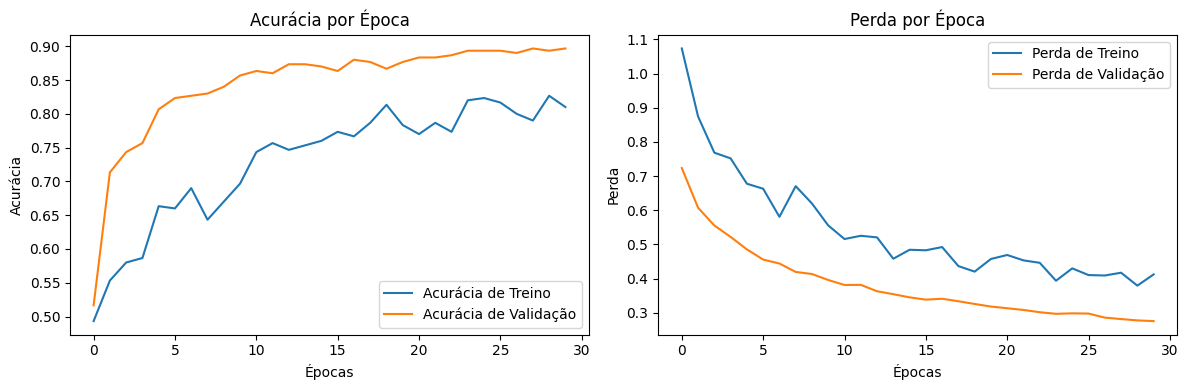

In [ ]:
# Plotagem do histórico de treinamento
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia por Época')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perda de Treino')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda por Época')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Geração de previsões no conjunto de teste
predictions = model.predict(test_gen)

# Obtenção das classes previstas e verdadeiras
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 692ms/step


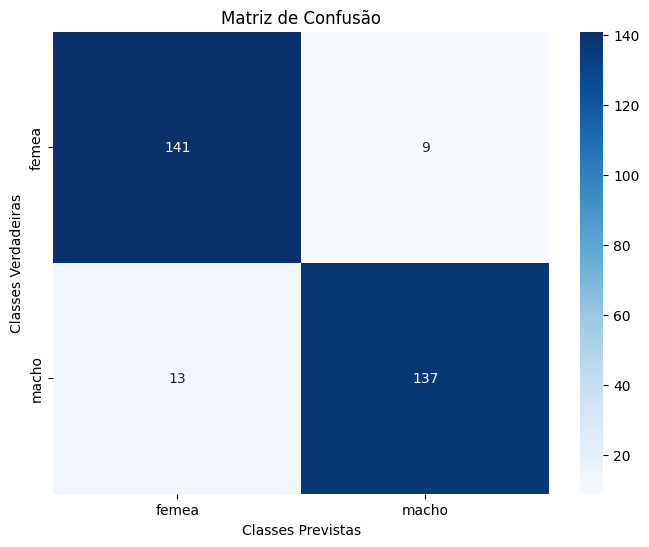

In [ ]:
# Matriz de confusão
cm = confusion_matrix(true_classes, predicted_classes)

# Plotagem da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusão')
plt.xlabel('Classes Previstas')
plt.ylabel('Classes Verdadeiras')
plt.show()


In [ ]:
# Cálculo das métricas
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')

print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Precisão: 0.93
Recall: 0.93
F1 Score: 0.93


In [ ]:
# Relatório de classificação
print("\nRelatório de Classificação:\n", classification_report(true_classes, predicted_classes, target_names=class_labels))



Relatório de Classificação:
               precision    recall  f1-score   support

       femea       0.92      0.94      0.93       150
       macho       0.94      0.91      0.93       150

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300



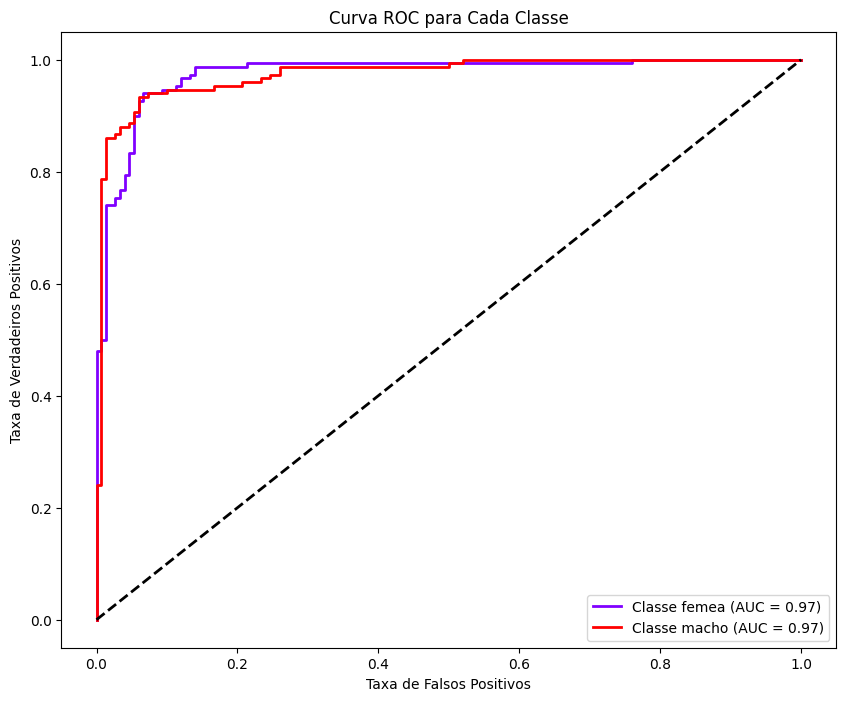

In [ ]:
# Curva ROC
# Binarização das classes verdadeiras
true_classes_bin = tf.keras.utils.to_categorical(true_classes, num_classes=num_classes)

# Definição das cores para cada classe
colors = cycle(plt.cm.rainbow(np.linspace(0, 1, num_classes)))

plt.figure(figsize=(10, 8))

for i, color in zip(range(num_classes), colors):
    fpr, tpr, _ = roc_curve(true_classes_bin[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'Classe {class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC para Cada Classe')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Descongela algumas camadas para fine-tuning
base_model = model.layers[0]  # Obter o modelo base
base_model.trainable = True

# Congela as primeiras camadas
fine_tune_at = 100  # Ajuste conforme necessário
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompilar o modelo com uma taxa de aprendizado menor
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continuar o treinamento
history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6405 - loss: 0.6473 - val_accuracy: 0.9000 - val_loss: 0.2745 - learning_rate: 1.0000e-05
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 607ms/step - accuracy: 0.6883 - loss: 0.5986 - val_accuracy: 0.9000 - val_loss: 0.2723 - learning_rate: 1.0000e-05
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 588ms/step - accuracy: 0.7144 - loss: 0.5949 - val_accuracy: 0.9000 - val_loss: 0.2707 - learning_rate: 1.0000e-05
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 720ms/step - accuracy: 0.7184 - loss: 0.5661 - val_accuracy: 0.9000 - val_loss: 0.2695 - learning_rate: 1.0000e-05
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 765ms/step - accuracy: 0.7701 - loss: 0.4491 - val_accuracy: 0.9033 - val_loss: 0.2662 - learning_rate: 1.0000e-05
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 741ms/step - accuracy: 0.7226 - loss: 0.4928 - val_accuracy: 0.9100 - val_loss: 0.2636 - learning_rate: 1.0000e-05
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 540ms/step - accura

In [ ]:
# Avaliação do modelo no conjunto de teste após fine-tuning
test_loss, test_acc = model.evaluate(test_gen)
print(f'Acurácia no teste após fine-tuning: {test_acc:.2f}')


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - accuracy: 0.8923 - loss: 0.2816
Acurácia no teste após fine-tuning: 0.93


In [ ]:
# Salvar o modelo treinado
model.save('modelo_macho_femea.h5')
